In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
brt_df = pd.read_csv("2022-cbs-pc6huisnr20210801_buurt/brt2022.csv", sep=";")
pc6_df = pd.read_csv("2022-cbs-pc6huisnr20210801_buurt/pc6hnr20220801_gwb.csv", sep=";")
geo_df = pd.read_excel("buurten all 2025-06-17 22.10.21.xlsx")
gdf = gpd.read_file("amsterdam_buurten.geojson")


In [14]:
brt_ams = brt_df[brt_df["GM_NAAM"] == "Amsterdam"]
pc6_ams = pc6_df[pc6_df["Gemeente2022"] == 363]

In [15]:
brt_sub = brt_ams[["buurtcode2022", "buurtnaam2022"]]
pc6_sub = pc6_ams[["PC6", "Buurt2022"]]

merged = pc6_sub.merge(brt_sub, left_on="Buurt2022", right_on="buurtcode2022", how="left")

merged = merged.merge(geo_df[["naam", "cbs_code"]], left_on="buurtnaam2022", right_on="naam", how="left")

pc_buurt = merged[["PC6", "cbs_code"]].dropna()
pc_buurt = pc_buurt.rename(columns={"PC6": "postcode6"})

In [16]:
pc_buurt.to_csv("pc6_to_buurt.csv", index=False)

In [3]:
cleaned_data = pd.read_csv("cleaned_household_data.csv")
postcode_buurt_map = pd.read_csv("pc6_to_buurt.csv")

cleaned_data["postcode6"] = cleaned_data["postcode6"].astype(str).str.replace(r"\s+", "", regex=True).str.upper()
postcode_buurt_map["postcode6"] = postcode_buurt_map["postcode6"].astype(str).str.replace(r"\s+", "", regex=True).str.upper()

merged = pd.merge(cleaned_data, postcode_buurt_map, on="postcode6", how="left")

amsterdam_data = merged[merged["cbs_code"].str.startswith("BU0363", na=False)].copy()
amsterdam_data["buurt_code"] = amsterdam_data["cbs_code"].str[-8:]

output_path = "Processed_ams_pc6_buurt_data.csv"
amsterdam_data.to_csv(output_path, index=False)

output_path


'Processed_ams_pc6_buurt_data.csv'

In [3]:
pc6_map = pd.read_csv("pc6_to_buurt.csv")  

data = pd.read_csv("cleaned_household_data.csv")  

data = data.merge(pc6_map, on="postcode6", how="left")

agg = data.groupby("cbs_code").agg({
    "elek_usage": "sum",
    "total_households": "sum"
}).reset_index()
agg["avg_usage"] = agg["elek_usage"] / agg["total_households"]


gdf = gdf.merge(agg[["cbs_code", "avg_usage"]], on="cbs_code", how="left")

gdf["centroid"] = gdf.geometry.centroid
gdf["x"] = gdf.centroid.x
gdf["y"] = gdf.centroid.y


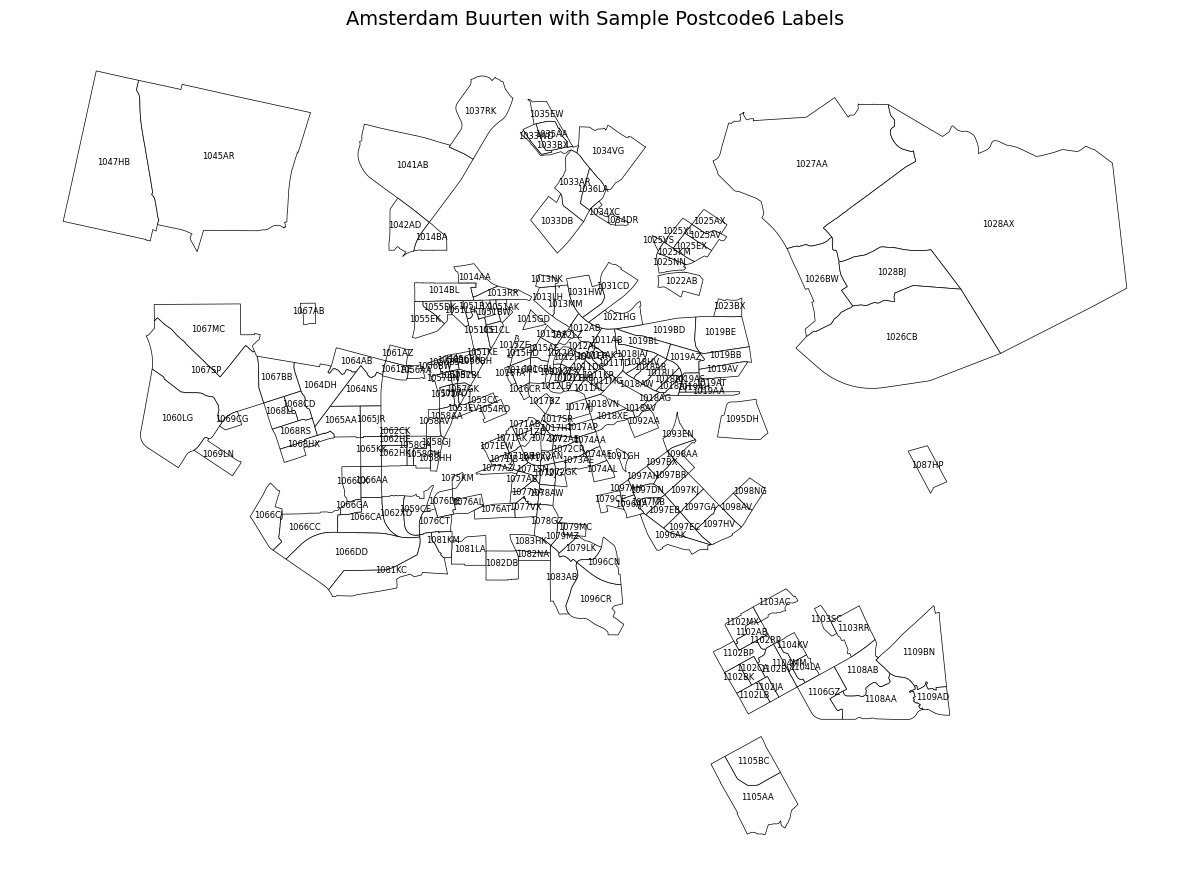

In [4]:
postcode_labels = pc6_map.groupby("cbs_code").first().reset_index()  
gdf = gdf.merge(postcode_labels, on="cbs_code", how="inner")

fig, ax = plt.subplots(figsize=(12, 12))

gdf.plot(ax=ax, edgecolor="black", facecolor="white", linewidth=0.5)

for idx, row in gdf.iterrows():
    if pd.notna(row["postcode6"]):
        plt.text(row["x"], row["y"], row["postcode6"], fontsize=6, ha="center")

plt.title("Amsterdam Buurten with Sample Postcode6 Labels", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

In [3]:
brt_path = "2022-cbs-pc6huisnr20210801_buurt/brt2022.csv"
brt_df = pd.read_csv(brt_path, sep=";")

brt_amsterdam = brt_df[brt_df["GM_NAAM"] == "Amsterdam"]

brt_amsterdam.to_csv("brt2022_amsterdam.csv", index=False)


In [4]:
pc6_path = "2022-cbs-pc6huisnr20210801_buurt/pc6hnr20220801_gwb.csv"
pc6_df = pd.read_csv(pc6_path, sep=";")

pc6_amsterdam = pc6_df[pc6_df["Gemeente2022"] == 363]

pc6_amsterdam.to_csv("pc6hnr2022_amsterdam.csv", index=False)


In [5]:
# mapping postcode6 to buurt in Amsterdam
brt = pd.read_csv("brt2022_amsterdam.csv")
pc6 = pd.read_csv("pc6hnr2022_amsterdam.csv")

brt_sub = brt[["buurtcode2022", "buurtnaam2022"]]
pc6_sub = pc6[["PC6", "Buurt2022"]]

merged = pc6_sub.merge(brt_sub, left_on="Buurt2022", right_on="buurtcode2022", how="left")

postcode_buurt_map = merged[["PC6", "Buurt2022", "buurtnaam2022"]].dropna()

postcode_buurt_map.to_csv("pc6_to_buurt_ams.csv", index=False)


In [7]:
pc_buurt = pd.read_csv("pc6_to_buurt_ams.csv")

geo_csv = pd.read_excel("buurten all 2025-06-17 22.10.21.xlsx") 

merged = pc_buurt.merge(geo_csv[["naam", "cbs_code"]], left_on="buurtnaam2022", right_on="naam", how="left")

merged[["PC6", "cbs_code"]].dropna().to_csv("pc6_to_cbs_code.csv", index=False)
